Correct Architecure from. Used weighted Dice Loss while training. Model appears to be decent. Used Batchnorm on the input layer

In [1]:
from google.colab import drive
import os
import pickle
import tensorflow_gcs_config
import shutil
import numpy as np
import tensorflow as tf
from keras import backend as K
from matplotlib import pyplot as plt
import nibabel as nib
import tensorflow_hub as hub
drive.mount('/content/MyDrive/')
os.chdir('/content/MyDrive/MyDrive/IDS705_Final') #change to file path on your disk

Mounted at /content/MyDrive/


In [2]:
#Create Train / Val / Test Split
subfolders = os.listdir("Data/Train")
np.random.seed(101)
split = np.random.choice(["Train","Val","Test"], len(subfolders), p=[0.6, 0.2, 0.2])
train_ids = [subfolders[i] for i,v in enumerate(split) if v=="Train"]
val_ids = [subfolders[i] for i,v in enumerate(split) if v=="Val"]
test_ids = [subfolders[i] for i,v in enumerate(split) if v=="Test"]

In [3]:
#Helper Functions

def parse_tfrecord(example):
  """
  This function helps in parsing tfrecord files when creating a TF Dataset object
  """
  feature = {'image': tf.io.FixedLenFeature([240, 240, 155, 4], tf.float32),
             'label': tf.io.FixedLenFeature([240, 240, 155], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

def get_image_and_label(features):
  """
  Extract Image and Label Object from tfrecord files
  """
  image, label = features['image'], features['label']
  return image, label

def get_dataset(tfrecord_names):
  """
  Create TF dataset files that can be fed into model functions
  """
  dataset = (tf.data.TFRecordDataset(tfrecord_names, num_parallel_reads=8)
             .map(parse_tfrecord)
             .map(get_image_and_label))

  return dataset

In [4]:
class Weighted_IOU(tf.keras.losses.Loss):
    def __init__(self, smooth=0, **kwargs):
        super().__init__(**kwargs)
        self.smooth = smooth
        pass

    def call(self, y_true, y_pred):
        y_true = tf.one_hot(y_true,5)
        intersection = K.sum(K.abs(y_true * y_pred), axis=(0,1,2,3)) + self.smooth
        union =  (K.sum(K.square(y_true), axis=(0,1,2,3)) + K.sum(K.square(y_pred), axis=(0,1,2,3))) + self.smooth
        ious = 1 - (2*intersection/union)
        return (ious[1] + ious[2] + ious[4]) / 3

In [5]:
#Create dataset objects
train_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in train_ids])
test_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in test_ids])
val_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in val_ids])
mini_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in subfolders[100:228]])
minival_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in subfolders[500:508]])

Model Architecture

In [ ]:
def gen_model(lr=1e-3):
    input_layer = tf.keras.layers.Input(shape=(240,240,155,4))

    x4 = tf.keras.layers.BatchNormalization()(input_layer)
    x4 = tf.keras.layers.Conv3D( 4, 3, strides=(1,1,1), activation='relu', padding='same')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv3D( 4, 3, strides=(1,1,1), activation='relu', padding='same')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)

    x8 = tf.keras.layers.Conv3D( 8, 3, strides=(2,2,2), activation='relu', padding='same')(x4)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv3D( 8, 3, strides=(1,1,1), activation='relu', padding='same')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)

    x16 = tf.keras.layers.Conv3D(16, 3, strides=(2,2,2), activation='relu', padding='same')(x8)
    x16 = tf.keras.layers.BatchNormalization()(x16)
    x16 = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x16)
    x16 = tf.keras.layers.BatchNormalization()(x16)

    x32 = tf.keras.layers.Conv3D(32, 3, strides=(2,2,2), activation='relu', padding='same')(x16)
    x32 = tf.keras.layers.BatchNormalization()(x32)
    x32 = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x32)
    x32 = tf.keras.layers.BatchNormalization()(x32)

    x64 = tf.keras.layers.Conv3D(64, 3, strides=(2,2,2), activation='relu', padding='same')(x32)
    x64 = tf.keras.layers.BatchNormalization()(x64)
    x64 = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x64)
    x64 = tf.keras.layers.BatchNormalization()(x64)
    
    x128 = tf.keras.layers.Conv3D(128, 3, strides=(2,2,2), activation='relu', padding='same')(x64)
    x128 = tf.keras.layers.BatchNormalization()(x128)
    x128 = tf.keras.layers.Conv3D(128, 3, strides=(1,1,1), activation='relu', padding='same')(x128)
    x128 = tf.keras.layers.BatchNormalization()(x128)

    x = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x128)
    x = tf.keras.layers.Cropping3D(cropping=((0,1), (0,1), (0,0)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x64], axis=-1)
    x = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(32, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x32], axis=-1)
    x = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(16, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,0), (0,0), (0,1)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x16], axis=-1)
    x = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(8, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x8], axis=-1)
    x = tf.keras.layers.Conv3D(8, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(4, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,0), (0,0), (0,1)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x4], axis=-1)
    x = tf.keras.layers.Conv3D(5, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    
    x = tf.keras.layers.Softmax(axis=-1)(x)
    
    full_model = tf.keras.Model(inputs=input_layer, outputs=x)
    full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=Weighted_IOU(smooth=1))
    return full_model


gpu_model = gen_model(lr=2e-4)
batchsize = 4
shufflesize = batchsize * 2

gpu_model.summary()
mini_dataset_trainable = mini_dataset.shuffle(shufflesize).batch(batchsize)
minival_dataset_validable = minival_dataset.batch(batchsize)
train_dataset_trainable = train_dataset.shuffle(shufflesize).batch(batchsize)
val_dataset_validable = val_dataset.batch(batchsize)

Main Training loop. best epoch from validation loss is saved as the model

In [ ]:
checkpoint_filepath = '/content/MyDrive/MyDrive/IDS705_Final/Models/Modelsgpu_07_20epr4'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, 
    save_best_only=True,
    monitor='val_loss',
    save_freq = 'epoch')
gpu_model_history = gpu_model.fit(train_dataset_trainable, epochs=6, callbacks=[model_checkpoint_callback], validation_data=val_dataset_validable, validation_batch_size=batchsize, )

Save model training history

In [ ]:
with open('/content/MyDrive/MyDrive/IDS705_Final/Models/Modelsgpu_05_20ep.hist', 'wb') as file_pi:
    pickle.dump(gpu_model.history, file_pi)

INFO:tensorflow:Assets written to: ram://40aee39b-ec55-45ff-a74e-b7891815153b/assets


Save model from last epoch

In [ ]:
gpu_model.save('/content/MyDrive/MyDrive/IDS705_Final/Models/Modelsgpu_07_20final')

INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/IDS705_Final/Models/Modelsgpu_05_20ep_final/assets


Load the saved model

In [7]:
gpu_model = tf.keras.models.load_model('/content/MyDrive/MyDrive/IDS705_Final/Models/Modelsgpu_07_20epr3', custom_objects={'Weighted_IOU': Weighted_IOU})

Visualize predictions

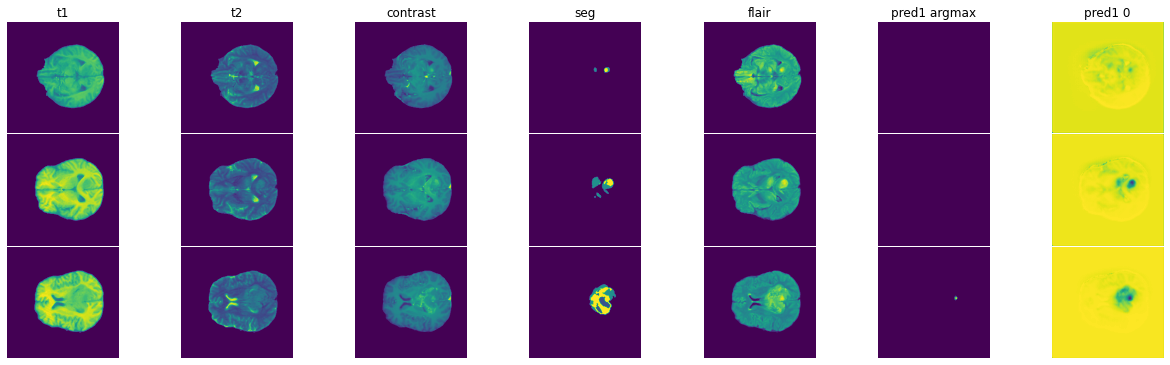

In [ ]:
plt.rcParams['axes.xmargin'] = 0

i=75

minipred_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in val_ids[i:(i+1)]])
minipred_dataset = minipred_dataset.batch(1)
pred1 = new_model.predict(minipred_dataset, batch_size=4)

subfolder_name = val_ids[i]
img1 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1.nii.gz') #file_format - nifti
img2 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t2.nii.gz') #file_format - nifti2
imgce = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1ce.nii.gz') #file_format - ce
imgseg = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_seg.nii.gz') #file_format - seg
imgflair = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_flair.nii.gz') #file_format - flair
slices = [60,70,80]

fig,axs = plt.subplots(len(slices),7,figsize=(18,5))
for j,slice_no in enumerate(slices):
    axs[j,0].imshow(img1.dataobj[:,:,slice_no])
    axs[j,1].imshow(img2.dataobj[:,:,slice_no])
    axs[j,2].imshow(imgce.dataobj[:,:,slice_no])
    axs[j,3].imshow(imgseg.dataobj[:,:,slice_no])
    axs[j,4].imshow(imgflair.dataobj[:,:,slice_no])
    axs[j,5].imshow(pred1[0,:,:,slice_no,:].argmax(2))
    axs[j,6].imshow(pred1[0,:,:,slice_no,0])
    # axs[j,0].set_ylabel("Slice "+str(slice_no))
    for jj in range(7):
      axs[j,jj].axis('off')

axs[0,0].set_title("t1")
axs[0,1].set_title("t2")
axs[0,2].set_title("contrast")
axs[0,3].set_title("seg")
axs[0,4].set_title("flair")
axs[0,5].set_title("pred1 argmax")
axs[0,6].set_title("pred1 0")
fig.tight_layout()



fig.subplots_adjust(
    top=0.981,
    bottom=0.049,
    left=0.042, 
    right=0.981,
    hspace=0.01,
    wspace=0.01,
)

In [ ]:
#tf.unique(pred1[0,:,:,:,:].argmax(3).flatten())
tf.unique(pred1[0,:,:,:,:].argmax(3).flatten())

Unique(y=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 4])>, idx=<tf.Tensor: shape=(8928000,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)